# Libraries & Packages

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
from scipy.interpolate import griddata
import numpy as np
import os
import glob
import rioxarray as rio
import rasterio as rio
from pyproj import Transformer
from esda.moran import Moran
from libpysal.weights import lat2W
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter
from skimage import filters

# Loading the file

In [59]:
sheet_names = ['Creamers', 'Farmers 1', 'Farmers 2', 'Tunnel']
dfs = pd.read_excel('/Users/Azadeh/CRREL.xlsx', sheet_name=sheet_names)
dfs

{'Creamers':      CF_Point       Point_ID  CF_Northing_m  CF_Easting_m  CF_Elev_m  \
 0         1.0  Creamers-0001    7193915.511    465013.469    134.482   
 1         2.0  Creamers-0002    7193918.897    465011.682    134.302   
 2         3.0  Creamers-0003    7193923.281    465011.427    134.370   
 3         4.0  Creamers-0004    7193927.196    465011.460    134.202   
 4         5.0  Creamers-0005    7193930.739    465010.849    134.077   
 ..        ...            ...            ...           ...        ...   
 124     125.0  CREAMERS-0125    7194401.601    464927.795    137.210   
 125     126.0  CREAMERS-0126    7194405.851    464926.465    137.405   
 126       NaN            NaN            NaN           NaN        NaN   
 127       NaN            NaN            NaN           NaN        NaN   
 128       NaN            NaN            NaN           NaN        NaN   
 
      CF_Dist_previous_m  CF_Dist_transect_m  CF_10_8_14  CF_09_29_15  \
 0              0.000000            0

### Changing Rows with Columns

In [47]:
df_Creamers = pd.read_excel('/Users/Azadeh/CRREL.xlsx', sheet_name='Creamers')

df_Creamers_selected = df_Creamers.iloc[:, 7:16]

df_Creamers_selected_transposed = df_Creamers_selected.transpose()

description_selected = df_Creamers_selected_transposed.describe()

df_Creamers_selected_transposed.to_csv('/Users/Azadeh/df_Creamers_selected_transposed.csv')
description_selected.to_csv('/Users/Azadeh/description_selected.csv')
description_selected


0          1          2          3           4          5    \
count    9.000000   9.000000   9.000000   9.000000    9.000000   9.000000   
mean    86.111111  67.666667  68.111111  70.111111   88.000000  82.111111   
std     20.787282   6.800735   5.441609   3.887301   11.368817   8.237786   
min     59.000000  57.000000  62.000000  64.000000   75.000000  66.000000   
25%     73.000000  64.000000  64.000000  67.000000   76.000000  79.000000   
50%     78.000000  69.000000  67.000000  70.000000   89.000000  82.000000   
75%    105.000000  70.000000  73.000000  72.000000   95.000000  89.000000   
max    121.000000  79.000000  78.000000  77.000000  107.000000  93.000000   

             6          7          8          9    ...        119        120  \
count   9.000000   9.000000   9.000000   9.000000  ...   9.000000   9.000000   
mean   68.000000  63.000000  74.666667  67.555556  ...  91.222222  88.111111   
std     5.830952   4.031129  10.920165   3.609401  ...   7.395569   4.400126   
min    57.000000  58.000000  56.000000  63.000000  ...  76.000000  83.000000   
25%    65.000000  60.000000  65.000000  65.000000  ...  88.000000  84.000000   
50%    68.000000  62.000000  79.000000  68.000000  ...  93.000000  88.000000   
75%    72.000000  66.000000  83.000000  69.000000  ...  96.000000  92.000000   
max    77.000000  70.000000  87.000000  74.000000  ...  99.000000  94.000000   

             121        122        123        124        125  126        127  \
count   9.000000   9.000000   9.000000   9.000000   9.000000  0.0   7.000000   
mean   85.444444  60.555556  68.777778  58.444444  84.666667  NaN  71.852599   
std     4.977728   9.408920   8.257993   5.456902   6.103278  NaN   4.501367   
min    76.000000  48.000000  49.000000  52.000000  75.000000  NaN  64.656000   
25%    83.000000  54.000000  68.000000  54.000000  82.000000  NaN  69.400095   
50%    86.000000  65.000000  69.000000  59.000000  86.000000  NaN  72.384000   
75%    87.000000  66.000000  74.000000  61.000000  89.000000  NaN  75.284000   
max    94.000000  75.000000  76.000000  69.000000  91.000000  NaN  76.560000   

             128  
count   7.000000  
mean   13.720168  
std     2.002072  
min    11.398571  
25%    11.925167  
50%    13.625796  
75%    15.618495  
max    15.929482  

[8 rows x 129 columns]

In [33]:
df_Creamers_selected_transposed

0     1     2     3      4     5     6     7     8     9    \
CF_10_8_14     67.0  70.0  67.0  72.0   76.0  89.0  77.0  70.0  80.0  74.0   
CF_09_29_15    59.0  57.0  62.0  72.0   89.0  85.0  72.0  66.0  83.0  68.0   
CF_10_10_16    73.0  64.0  64.0  69.0   75.0  81.0  70.0  67.0  74.0  68.0   
CF 10_2017     78.0  59.0  63.0  67.0   75.0  75.0  63.0  61.0  56.0  63.0   
CF 10_5_2018   78.0  69.0  65.0  67.0   84.0  79.0  65.0  58.0  65.0  63.0   
CF 10_15_19    86.0  69.0  68.0  73.0   93.0  89.0  68.0  62.0  79.0  67.0   
CF 10_6_20    105.0  79.0  78.0  77.0  107.0  93.0  72.0  64.0  85.0  71.0   
CF 10_2_21    121.0  69.0  73.0  64.0   95.0  66.0  57.0  60.0  63.0  65.0   
CF_9_28_22    108.0  73.0  73.0  70.0   98.0  82.0  68.0  59.0  87.0  69.0   

              ...   119   120   121   122   123   124   125  126       127  \
CF_10_8_14    ...  84.0  87.0  83.0  48.0  66.0  60.0  76.0  NaN  66.97619   
CF_09_29_15   ...  76.0  83.0  76.0  66.0  49.0  52.0  75.0  NaN  64.65600   
CF_10_10_16   ...  88.0  94.0  94.0  66.0  68.0  62.0  89.0  NaN  75.36000   
CF 10_2017    ...  96.0  94.0  87.0  56.0  68.0  59.0  86.0  NaN  71.82400   
CF 10_5_2018  ...  93.0  92.0  87.0  54.0  69.0  52.0  82.0  NaN  72.38400   
CF 10_15_19   ...  99.0  88.0  86.0  75.0  74.0  57.0  89.0  NaN  75.20800   
CF 10_6_20    ...  98.0  88.0  89.0  65.0  75.0  69.0  91.0  NaN  76.56000   
CF 10_2_21    ...  94.0  84.0  85.0  67.0  74.0  61.0  91.0  NaN       NaN   
CF_9_28_22    ...  93.0  83.0  82.0  48.0  76.0  54.0  83.0  NaN       NaN   

                    128  
CF_10_8_14    11.398571  
CF_09_29_15   12.154320  
CF_10_10_16   11.696015  
CF 10_2017    13.625796  
CF 10_5_2018  15.536006  
CF 10_15_19   15.700984  
CF 10_6_20    15.929482  
CF 10_2_21          NaN  
CF_9_28_22          NaN  

[9 rows x 129 columns]

In [3]:
import pandas as pd

file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'

excel_data = pd.read_excel(file_path, sheet_name=None)

location_counts = {sheet: len(data) for sheet, data in excel_data.items()}

for sheet, count in location_counts.items():
    print(f"The sheet '{sheet}' has {count} locations.")


The sheet 'Creamers' has 126 locations.
The sheet 'Farmers 1' has 101 locations.
The sheet 'Farmers 2' has 126 locations.
The sheet 'Tunnel' has 92 locations.
The sheet 'NaN_Values' has 46 locations.


# Histogram on the Excel file

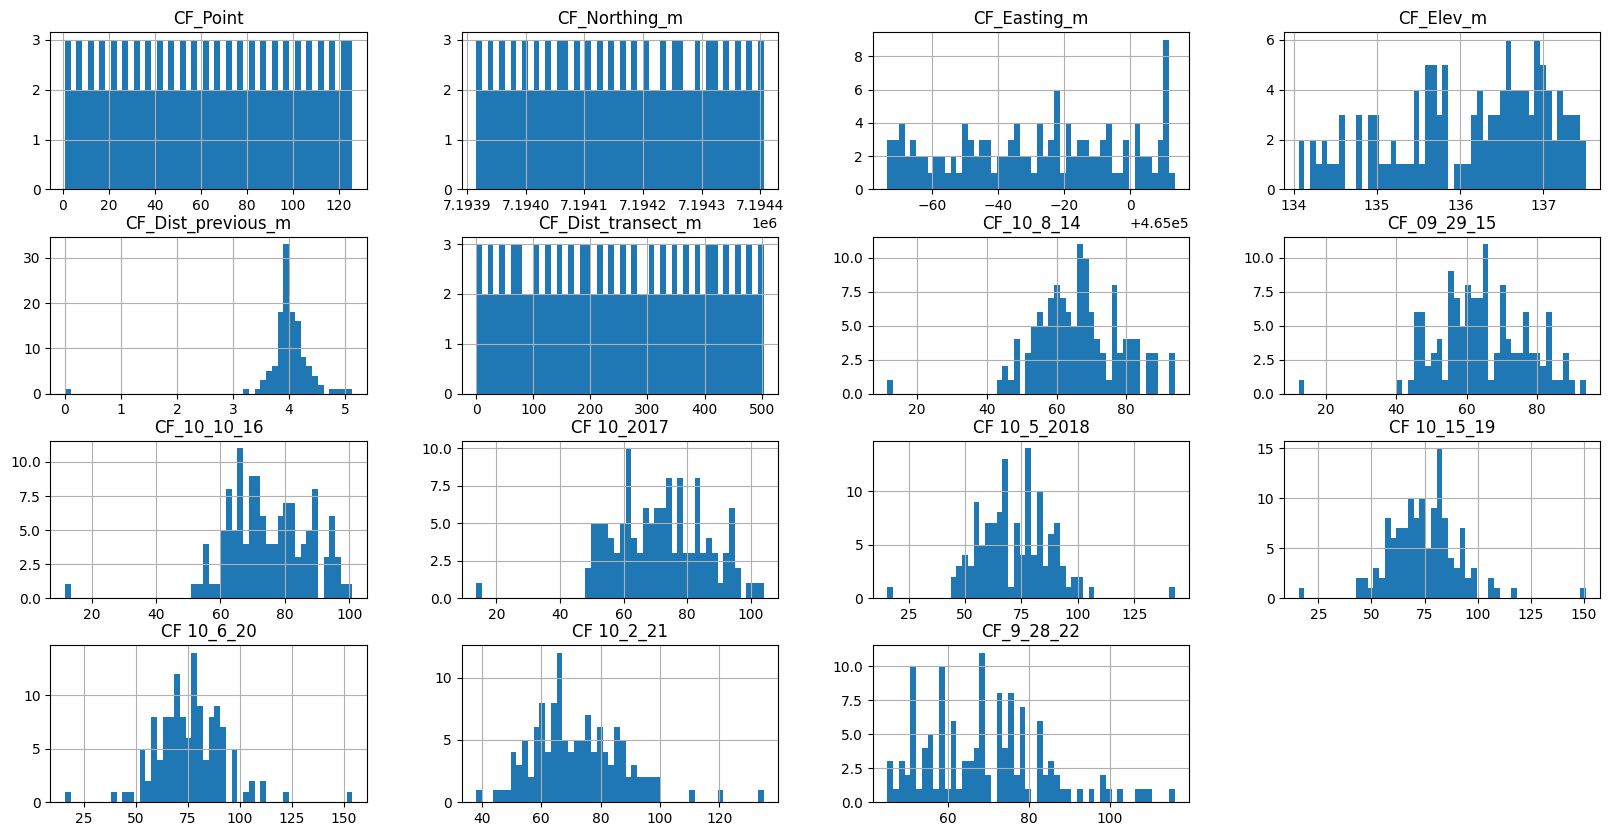

In [61]:
df = pd.read_excel('/Users/Azadeh/CRREL.xlsx')
_ = df.hist(bins=50 , figsize=(20, 10))

### Dealing with NAN values and making CRREL_cleaned Excel file without NAN values

In [54]:
def check_missing_values(dfs):
    missing_values_summary = {}
    for sheet_name, dfs in dfs.items():
        missing_values = dfs.isnull().sum()
        missing_values_summary[sheet_name] = missing_values
    return missing_values_summary

missing_values_summary = check_missing_values(dfs)

for sheet_name, missing_values in missing_values_summary.items():
    print(f"Missing values in sheet '{sheet_name}':")
    print(missing_values)
    print("\n")

Missing values in sheet 'Creamers':
CF_Point              3
Point_ID              3
CF_Northing_m         3
CF_Easting_m          3
CF_Elev_m             3
CF_Dist_previous_m    3
CF_Dist_transect_m    3
CF_10_8_14            1
CF_09_29_15           1
CF_10_10_16           1
CF 10_2017            1
CF 10_5_2018          1
CF 10_15_19           1
CF 10_6_20            1
CF 10_2_21            3
CF_9_28_22            3
CF_Notes_22           3
dtype: int64


Missing values in sheet 'Farmers 1':
FL1_Point              28
Point_ID               28
FL1_Northing_m         28
FL1_Easting_m          28
FL1_Elev_m             28
FL1_Dist_previous_m    28
FL1_Dist_transect_m    28
F1_10_7_14             24
F1_09_29_15            24
F1_10_10_16            24
F1 10_3_2017           26
F1 10_10_18            26
FL1_10_14_19           26
FL1_10_5_20            26
9_30_21                26
FL1_9_27_22            28
Type                   28
dtype: int64


Missing values in sheet 'Farmers 2':
FL2_Point 

In [55]:
def display_nan_rows(dfs):
    for sheet_name, df in dfs.items():
        nan_rows = df[df.isnull().any(axis=1)]
        
        if not nan_rows.empty:
            print(f"Rows with NaN values in sheet '{sheet_name}':")
            print(nan_rows)
            print("\n")
        else:
            print(f"No NaN values in sheet '{sheet_name}'\n")

display_nan_rows(dfs)


Rows with NaN values in sheet 'Creamers':
     CF_Point Point_ID  CF_Northing_m  CF_Easting_m  CF_Elev_m  \
126       NaN      NaN            NaN           NaN        NaN   
127       NaN      NaN            NaN           NaN        NaN   
128       NaN      NaN            NaN           NaN        NaN   

     CF_Dist_previous_m  CF_Dist_transect_m  CF_10_8_14  CF_09_29_15  \
126                 NaN                 NaN         NaN          NaN   
127                 NaN                 NaN   66.976190     64.65600   
128                 NaN                 NaN   11.398571     12.15432   

     CF_10_10_16  CF 10_2017  CF 10_5_2018  CF 10_15_19  CF 10_6_20  \
126          NaN         NaN           NaN          NaN         NaN   
127    75.360000   71.824000     72.384000    75.208000   76.560000   
128    11.696015   13.625796     15.536006    15.700984   15.929482   

     CF 10_2_21  CF_9_28_22 CF_Notes_22  
126         NaN         NaN         NaN  
127         NaN         NaN        

In [56]:
def store_nan_rows(dfs):
    nan_rows_dict = {}
    for sheet_name, df in dfs.items():
        nan_rows = df[df.isnull().any(axis=1)]
        nan_rows_dict[sheet_name] = nan_rows
    return nan_rows_dict

nan_rows_dict = store_nan_rows(dfs)

for sheet_name, nan_rows in nan_rows_dict.items():
    if not nan_rows.empty:
        print(f"Rows with NaN values in sheet '{sheet_name}':")
        print(nan_rows)
        print("\n")
    else:
        print(f"No NaN values in sheet '{sheet_name}'\n")


Rows with NaN values in sheet 'Creamers':
     CF_Point Point_ID  CF_Northing_m  CF_Easting_m  CF_Elev_m  \
126       NaN      NaN            NaN           NaN        NaN   
127       NaN      NaN            NaN           NaN        NaN   
128       NaN      NaN            NaN           NaN        NaN   

     CF_Dist_previous_m  CF_Dist_transect_m  CF_10_8_14  CF_09_29_15  \
126                 NaN                 NaN         NaN          NaN   
127                 NaN                 NaN   66.976190     64.65600   
128                 NaN                 NaN   11.398571     12.15432   

     CF_10_10_16  CF 10_2017  CF 10_5_2018  CF 10_15_19  CF 10_6_20  \
126          NaN         NaN           NaN          NaN         NaN   
127    75.360000   71.824000     72.384000    75.208000   76.560000   
128    11.696015   13.625796     15.536006    15.700984   15.929482   

     CF 10_2_21  CF_9_28_22 CF_Notes_22  
126         NaN         NaN         NaN  
127         NaN         NaN        

In [57]:
def drop_nan_values(dfs):
    cleaned_dfs = {}
    for sheet_name, df in dfs.items():
        cleaned_df = df.dropna()
        cleaned_dfs[sheet_name] = cleaned_df
    return cleaned_dfs

cleaned_dfs = drop_nan_values(dfs)


In [58]:
new_file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'

with pd.ExcelWriter(new_file_path) as writer:
    for sheet_name, cleaned_df in cleaned_dfs.items():
        cleaned_df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    nan_combined_df = pd.concat(nan_rows_dict, axis=0)
    nan_combined_df.to_excel(writer, sheet_name='NaN_Values', index=True)


In [61]:
for sheet_name, df in dfs.items():
    print(f"Info for sheet '{sheet_name}':")
    print(df.info())
    print("\n")

Info for sheet 'Creamers':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CF_Point            126 non-null    float64
 1   Point_ID            126 non-null    object 
 2   CF_Northing_m       126 non-null    float64
 3   CF_Easting_m        126 non-null    float64
 4   CF_Elev_m           126 non-null    float64
 5   CF_Dist_previous_m  126 non-null    float64
 6   CF_Dist_transect_m  126 non-null    float64
 7   CF_10_8_14          128 non-null    float64
 8   CF_09_29_15         128 non-null    float64
 9   CF_10_10_16         128 non-null    float64
 10  CF 10_2017          128 non-null    float64
 11  CF 10_5_2018        128 non-null    float64
 12  CF 10_15_19         128 non-null    float64
 13  CF 10_6_20          128 non-null    float64
 14  CF 10_2_21          126 non-null    float64
 15  CF_9_28_22          126 non-nu

### Folium HTML MAP and Transects Locations

In [12]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster

sheet_names = ['Creamers', 'Farmers 1', 'Farmers 2', 'Tunnel']
excel_file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'

latitude_columns = {
    'Creamers': 'CF_Northing_m',
    'Farmers 1': 'FL1_Northing_m',
    'Farmers 2': 'FL2_Northing_m',
    'Tunnel': 'PT_Northing_m'
}
longitude_columns = {
    'Creamers': 'CF_Easting_m',
    'Farmers 1': 'FL1_Easting_m',
    'Farmers 2': 'FL2_Easting_m',
    'Tunnel': 'PT_Easting_m'
}

gdfs = []

for sheet_name in sheet_names:
    df = pd.read_excel(excel_file_path, sheet_name=sheet_name)
    lat_col = latitude_columns[sheet_name]
    lon_col = longitude_columns[sheet_name]
    
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    
    gdf.crs = 'EPSG:32606'
    
    gdf = gdf.to_crs(epsg=4326)
    
    gdf['latitude'] = gdf.geometry.y
    gdf['longitude'] = gdf.geometry.x
    
    gdf['Sheet'] = sheet_name
    
    gdfs.append(gdf)

all_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

map_center = [all_gdf['latitude'].mean(), all_gdf['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=10)

marker_cluster = MarkerCluster().add_to(m)

all_gdf.apply(
    lambda row: folium.Marker(
        location=[row['latitude'], row['longitude']], 
        popup=f"Point ID: {row.get('CF_Point', 'N/A')}, Sheet: {row['Sheet']}"
    ).add_to(marker_cluster),
    axis=1
)

map_path = '/Users/Azadeh/frost_probing_locations8.html'
m.save(map_path)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


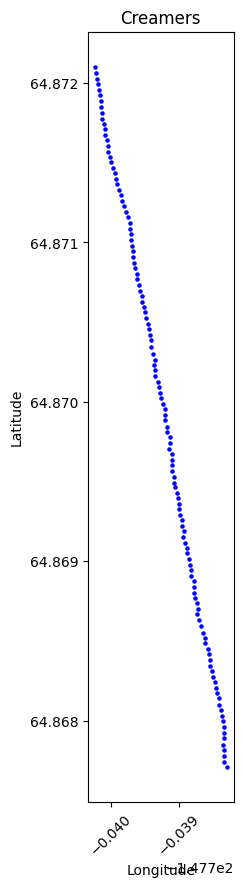

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

excel_file = '/Users/Azadeh/CRREL_cleaned.xlsx'
df = pd.read_excel(excel_file, sheet_name='Creamers')

geometry = [Point(xy) for xy in zip(df['CF_Easting_m'], df['CF_Northing_m'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

gdf.crs = 'EPSG:32606'

gdf = gdf.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, marker='o', color='blue', markersize=5)
ax.set_title('Creamers')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.xticks(rotation=45)

plt.savefig('Creamers.jpg', format='jpeg', dpi=300)
plt.show()


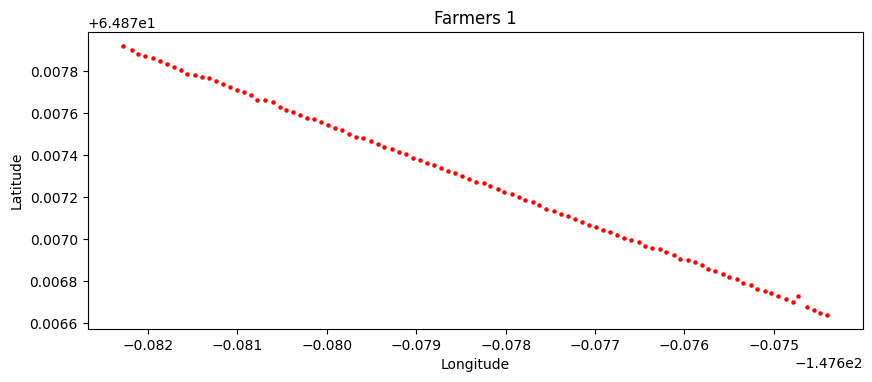

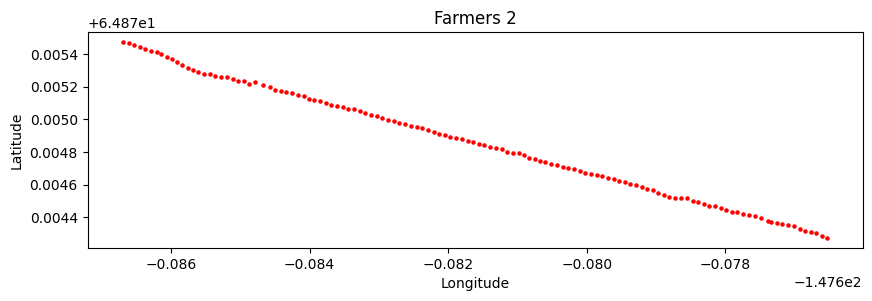

In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

excel_file = '/Users/Azadeh/CRREL.xlsx'

# Code for Farmers 1
df_farmers1 = pd.read_excel(excel_file, sheet_name='Farmers 1')

geometry_farmers1 = [Point(xy) for xy in zip(df_farmers1['FL1_Easting_m'], df_farmers1['FL1_Northing_m'])]
gdf_farmers1 = gpd.GeoDataFrame(df_farmers1, geometry=geometry_farmers1)

gdf_farmers1.crs = 'EPSG:32606'
gdf_farmers1 = gdf_farmers1.to_crs(epsg=4326)

fig_farmers1, ax_farmers1 = plt.subplots(figsize=(10, 5))
gdf_farmers1.plot(ax=ax_farmers1, marker='o', color='red', markersize=5)
ax_farmers1.set_title('Farmers 1')
ax_farmers1.set_xlabel('Longitude')
ax_farmers1.set_ylabel('Latitude')

plt.xticks(rotation=0)
plt.savefig('/Users/Azadeh/farmers1_plot.jpg', format='jpeg', dpi=300)
plt.show()

# Code for Farmers 2
df_farmers2 = pd.read_excel(excel_file, sheet_name='Farmers 2')

geometry_farmers2 = [Point(xy) for xy in zip(df_farmers2['FL2_Easting_m'], df_farmers2['FL2_Northing_m'])]
gdf_farmers2 = gpd.GeoDataFrame(df_farmers2, geometry=geometry_farmers2)

gdf_farmers2.crs = 'EPSG:32606'
gdf_farmers2 = gdf_farmers2.to_crs(epsg=4326)

fig_farmers2, ax_farmers2 = plt.subplots(figsize=(10, 5))
gdf_farmers2.plot(ax=ax_farmers2, marker='o', color='red', markersize=5)
ax_farmers2.set_title('Farmers 2')
ax_farmers2.set_xlabel('Longitude')
ax_farmers2.set_ylabel('Latitude')

plt.xticks(rotation=0)
plt.savefig('/Users/Azadeh/farmers2_plot.jpg', format='jpeg', dpi=300)
plt.show()

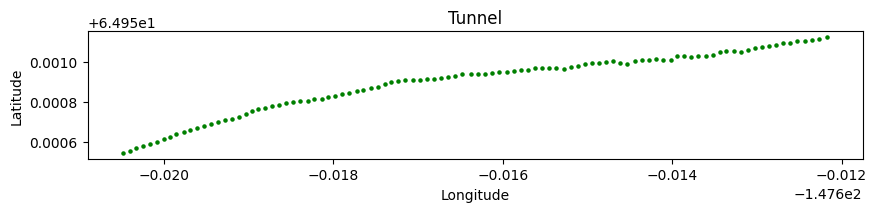

In [5]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

excel_file = '/Users/Azadeh/CRREL.xlsx'
df = pd.read_excel(excel_file, sheet_name='Tunnel')

geometry = [Point(xy) for xy in zip(df['PT_Easting_m'], df['PT_Northing_m'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

gdf.crs = 'EPSG:32606'

gdf = gdf.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 5))
gdf.plot(ax=ax, marker='o', color='green', markersize=5)
ax.set_title('Tunnel')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.xticks(rotation=0)
plt.savefig('/Users/Azadeh/Tunnel.jpg', format='jpeg', dpi=300)
plt.show()


### Euclidean Distance

In [56]:
import pandas as pd
import numpy as np

file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'
excel_data = pd.ExcelFile(file_path)

def calculate_distance(easting1, northing1, easting2, northing2):
    return np.sqrt((easting2 - easting1) ** 2 + (northing2 - northing1) ** 2)

distances_dict = {}
differences_dict = {}

for sheet in excel_data.sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet)
    
    easting_cols = [col for col in df.columns if col.endswith('_Easting_m')]
    northing_cols = [col for col in df.columns if col.endswith('_Northing_m')]
    
    if len(easting_cols) > 0 and len(northing_cols) > 0:
        easting_col = easting_cols[0]
        northing_col = northing_cols[0]
        
        distances = []
        differences = []
        for i in range(1, len(df)):
            calculated_distance = calculate_distance(
                df[easting_col].iloc[i-1], df[northing_col].iloc[i-1],
                df[easting_col].iloc[i], df[northing_col].iloc[i]
            )
            distances.append(calculated_distance)
            
            distance_col = [col for col in df.columns if col.endswith('_Dist_previous_m')]
            if distance_col:
                actual_distance = df[distance_col[0]].iloc[i]
                difference = actual_distance - calculated_distance
                differences.append(difference)
            else:
                differences.append(np.nan)
        
        distances_dict[sheet] = distances
        differences_dict[sheet] = differences

distances_df = pd.DataFrame({sheet: pd.Series(data) for sheet, data in distances_dict.items()})
differences_df = pd.DataFrame({sheet: pd.Series(data) for sheet, data in differences_dict.items()})

result_df = pd.concat([distances_df.add_suffix('_Calculated_Distance'), differences_df.add_suffix('_Difference')], axis=1)

print(result_df)

result_df.to_csv('/Users/Azadeh/distances_and_differences3.csv', index=False)

for sheet, distances in distances_dict.items():
    avg_distance = np.mean(distances)
    print(f"Average calculated Euclidean distance in sheet {sheet}: {avg_distance:.2f} meters")

print("Euclidean Distances and differences have been calculated and saved to 'distances_and_differences3.csv'.")


     Creamers_Calculated_Distance  Farmers 1_Calculated_Distance  \
0                        3.828624                       3.931998   
1                        4.391410                       3.875687   
2                        3.915139                       4.057837   
3                        3.595298                       7.272491   
4                        4.893889                       4.095953   
..                            ...                            ...   
120                      3.939527                            NaN   
121                      3.863510                            NaN   
122                      4.269685                            NaN   
123                      4.042746                            NaN   
124                      4.453246                            NaN   

     Farmers 2_Calculated_Distance  Tunnel_Calculated_Distance  \
0                         3.959297                    4.054110   
1                         4.211515                 

### First Best Graphs

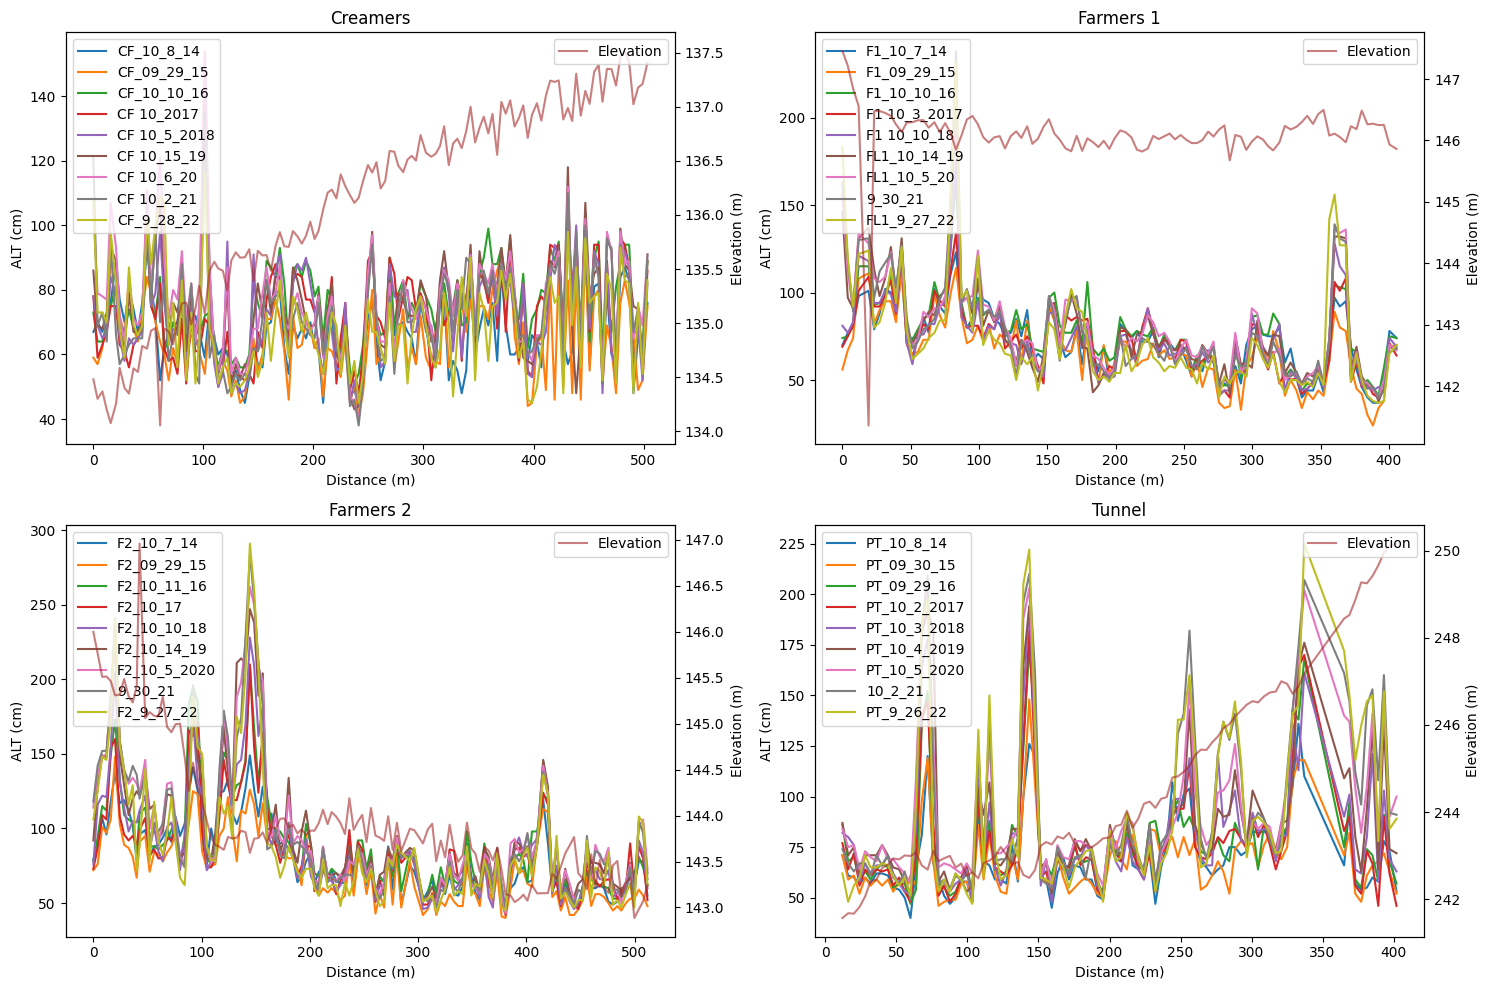

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'
sheets = ['Creamers', 'Farmers 1', 'Farmers 2', 'Tunnel']
titles = ['Creamers', 'Farmers 1', 'Farmers 2', 'Tunnel']
distance_cols = ['CF_Dist_transect_m', 'FL1_Dist_transect_m', 'FL2_Dist_transect_m', 'PT_Dist_transect_m']
alt_cols = [
    ['CF_10_8_14', 'CF_09_29_15', 'CF_10_10_16', 'CF 10_2017', 'CF 10_5_2018', 'CF 10_15_19', 'CF 10_6_20', 'CF 10_2_21', 'CF_9_28_22'],
    ['F1_10_7_14', 'F1_09_29_15', 'F1_10_10_16', 'F1 10_3_2017', 'F1 10_10_18', 'FL1_10_14_19', 'FL1_10_5_20', '9_30_21', 'FL1_9_27_22'],
    ['F2_10_7_14', 'F2_09_29_15', 'F2_10_11_16', 'F2_10_17', 'F2_10_10_18', 'F2_10_14_19', 'F2_10_5_2020', '9_30_21', 'F2_9_27_22'],
    ['PT_10_8_14', 'PT_09_30_15', 'PT_09_29_16', 'PT_10_2_2017', 'PT_10_3_2018', 'PT_10_4_2019', 'PT_10_5_2020', '10_2_21', 'PT_9_26_22']
]
elevation_cols = ['CF_Elev_m', 'FL1_Elev_m', 'FL2_Elev_m', 'PT_Elev_m']

def create_subplot(ax, data, distance_col, alt_cols, elevation_col, title):
    for col in alt_cols:
        if col in data.columns:
            ax.plot(data[distance_col], data[col], label=col)
    
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('ALT (cm)')
    ax.set_title(title)

    # Create a secondary y-axis for elevation
    ax2 = ax.twinx()
    if elevation_col in data.columns:
        ax2.plot(data[distance_col], data[elevation_col], color='brown', alpha=0.6, label='Elevation')
    ax2.set_ylabel('Elevation (m)')
    
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

data_creamers = pd.read_excel(file_path, sheet_name='Creamers')
data_farmers1 = pd.read_excel(file_path, sheet_name='Farmers 1')
data_farmers2 = pd.read_excel(file_path, sheet_name='Farmers 2')
data_tunnel = pd.read_excel(file_path, sheet_name='Tunnel')

create_subplot(axs[0, 0], data_creamers, 'CF_Dist_transect_m', alt_cols[0], 'CF_Elev_m', 'Creamers')
create_subplot(axs[0, 1], data_farmers1, 'FL1_Dist_transect_m', alt_cols[1], 'FL1_Elev_m', 'Farmers 1')
create_subplot(axs[1, 0], data_farmers2, 'FL2_Dist_transect_m', alt_cols[2], 'FL2_Elev_m', 'Farmers 2')
create_subplot(axs[1, 1], data_tunnel, 'PT_Dist_transect_m', alt_cols[3], 'PT_Elev_m', 'Tunnel')

plt.tight_layout()
plt.show()


# Scatter Plot

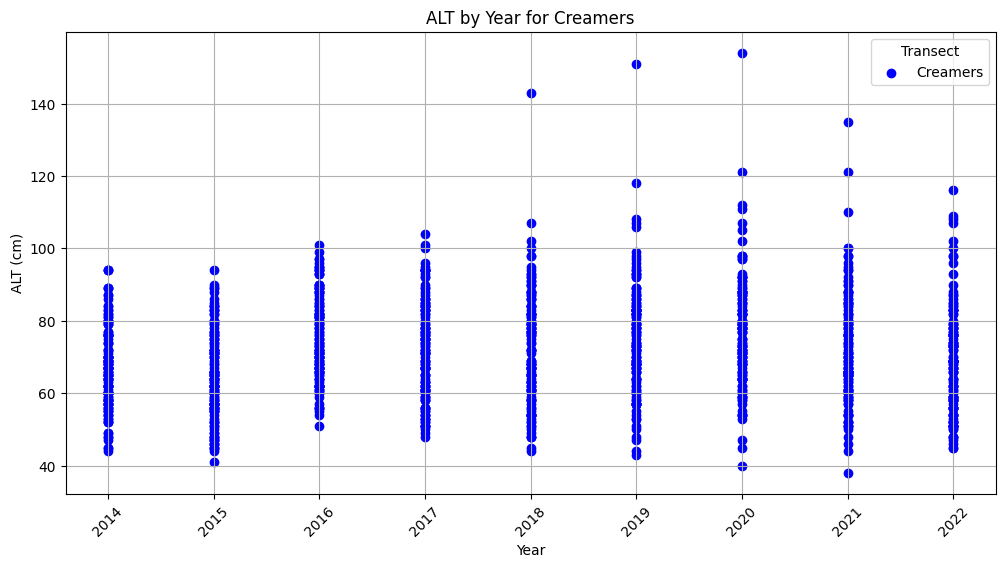

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/Azadeh/CRREL.xlsx'
sheets = ['Creamers', 'Farmers 1', 'Farmers 2', 'Tunnel']

columns_dict = {
    'Creamers': {
        'dist': 'CF_Dist_transect_m',
        'alt': {
            'CF_10_8_14': 2014,
            'CF_09_29_15': 2015,
            'CF_10_10_16': 2016,
            'CF 10_2017': 2017,
            'CF 10_5_2018': 2018,
            'CF 10_15_19': 2019,
            'CF 10_6_20': 2020,
            'CF 10_2_21': 2021,
            'CF_9_28_22': 2022
        }
    },
    'Farmers 1': {
        'dist': 'FL1_Dist_transect_m',
        'alt': {
            'F1_10_7_14': 2014,
            'F1_09_29_15': 2015,
            'F1_10_10_16': 2016,
            'F1 10_3_2017': 2017,
            'F1 10_10_18': 2018,
            'FL1_10_14_19': 2019,
            'FL1_10_5_20': 2020,
            '9_30_21': 2021,
            'FL1_9_27_22': 2022
        }
    },
    'Farmers 2': {
        'dist': 'FL2_Dist_transect_m',
        'alt': {
            'F2_10_7_14': 2014,
            'F2_09_29_15': 2015,
            'F2_10_11_16': 2016,
            'F2_10_17': 2017,
            'F2_10_10_18': 2018,
            'F2_10_14_19': 2019,
            'F2_10_5_2020': 2020,
            '9_30_21': 2021,
            'F2_9_27_22': 2022
        }
    },
    'Tunnel': {
        'dist': 'PT_Dist_transect_m',
        'alt': {
            'PT_10_8_14': 2014,
            'PT_09_30_15': 2015,
            'PT_09_29_16': 2016,
            'PT_10_2_2017': 2017,
            'PT_10_3_2018': 2018,
            'PT_10_4_2019': 2019,
            'PT_10_5_2020': 2020,
            '10_2_21': 2021,
            'PT_9_26_22': 2022
        }
    }
}

def gather_alt_data(sheet_name, dist_col, alt_columns):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    alt_data_by_year = pd.DataFrame()

    for alt_col, year in alt_columns.items():
        temp_df = df[[dist_col, alt_col]].dropna().copy()
        temp_df = temp_df.rename(columns={dist_col: 'Transect_Distance', alt_col: 'ALT'})
        temp_df['Year'] = year
        temp_df['Location'] = sheet_name
        alt_data_by_year = pd.concat([alt_data_by_year, temp_df])

    return alt_data_by_year

all_data = pd.DataFrame()
for sheet in sheets:
    sheet_data = gather_alt_data(sheet, columns_dict[sheet]['dist'], columns_dict[sheet]['alt'])
    all_data = pd.concat([all_data, sheet_data])

plt.figure(figsize=(12, 6))
creamers_data = all_data[all_data['Location'] == 'Creamers']
plt.scatter(creamers_data['Year'], creamers_data['ALT'], color='blue', label='Creamers')
plt.title('ALT by Year for Creamers')
plt.xlabel('Year')
plt.ylabel('ALT (cm)')
plt.legend(title='Transect')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


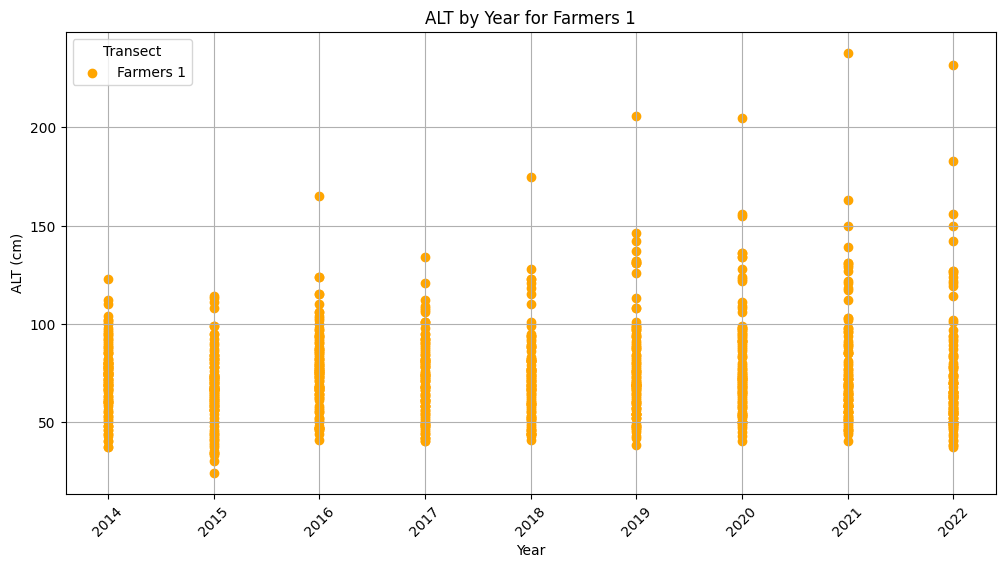

In [8]:
# Scatter plot for Farmers 1
plt.figure(figsize=(12, 6))
farmers1_data = all_data[all_data['Location'] == 'Farmers 1']
plt.scatter(farmers1_data['Year'], farmers1_data['ALT'], color='orange', label='Farmers 1')
plt.title('ALT by Year for Farmers 1')
plt.xlabel('Year')
plt.ylabel('ALT (cm)')
plt.legend(title='Transect')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


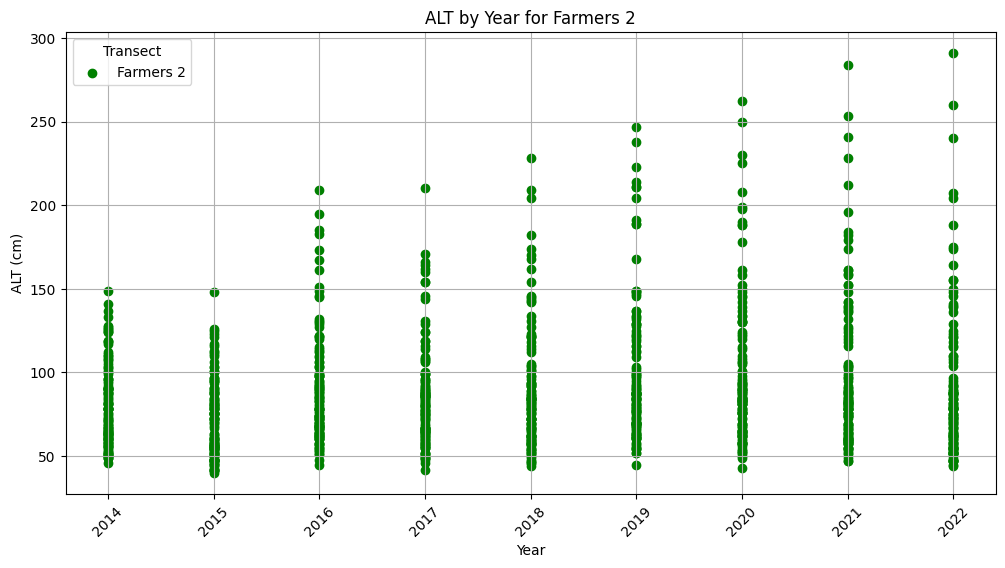

In [9]:
# Scatter plot for Farmers 2
plt.figure(figsize=(12, 6))
farmers2_data = all_data[all_data['Location'] == 'Farmers 2']
plt.scatter(farmers2_data['Year'], farmers2_data['ALT'], color='green', label='Farmers 2')
plt.title('ALT by Year for Farmers 2')
plt.xlabel('Year')
plt.ylabel('ALT (cm)')
plt.legend(title='Transect')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


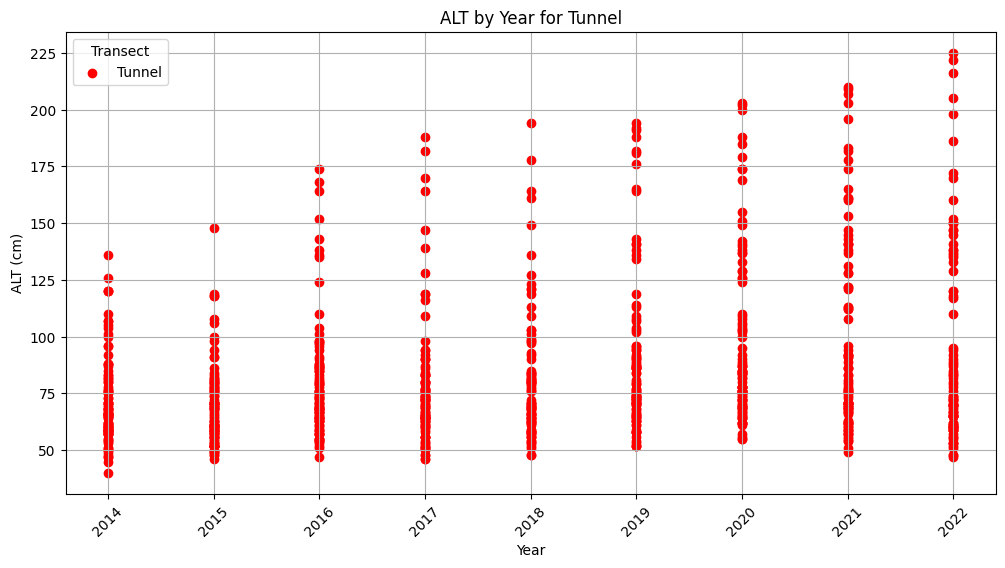

In [10]:
# Scatter plot for Tunnel
plt.figure(figsize=(12, 6))
tunnel_data = all_data[all_data['Location'] == 'Tunnel']
plt.scatter(tunnel_data['Year'], tunnel_data['ALT'], color='red', label='Tunnel')
plt.title('ALT by Year for Tunnel')
plt.xlabel('Year')
plt.ylabel('ALT (cm)')
plt.legend(title='Transect')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


# Heatmap

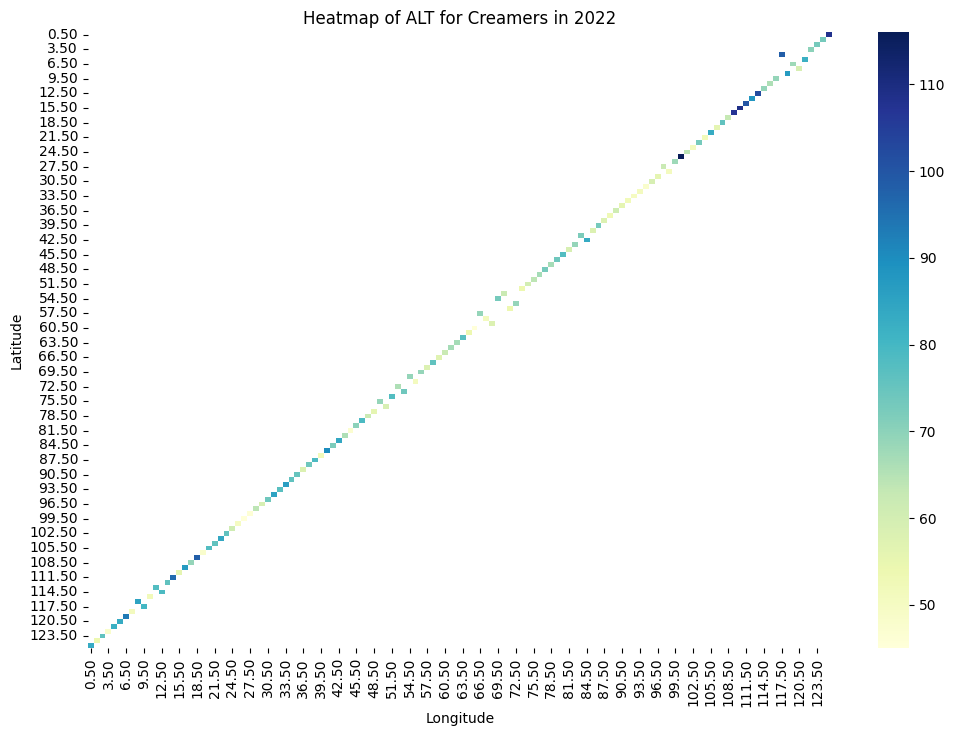

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyproj import Transformer

file_path = '/Users/Azadeh/CRREL.xlsx'
df = pd.read_excel(file_path, sheet_name='Creamers')

transformer = Transformer.from_crs("epsg:32606", "epsg:4326", always_xy=True)

easting_values = df['CF_Easting_m'].values
northing_values = df['CF_Northing_m'].values

longitudes, latitudes = transformer.transform(easting_values, northing_values)

df['longitude'] = longitudes
df['latitude'] = latitudes

pivot_table = df.pivot_table(values='CF_9_28_22', index='latitude', columns='longitude')

plt.figure(figsize=(12, 8))
ax = sns.heatmap(pivot_table, cmap="YlGnBu")

ax.set_xticklabels([f'{x:.2f}' for x in ax.get_xticks()], rotation=90)
ax.set_yticklabels([f'{y:.2f}' for y in ax.get_yticks()], rotation=0)

plt.title('Heatmap of ALT for Creamers in 2022')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.savefig('heatmap_ALT_Creamers in 2022.jpg', format='jpeg', dpi=300)

plt.show()


# Linegraph

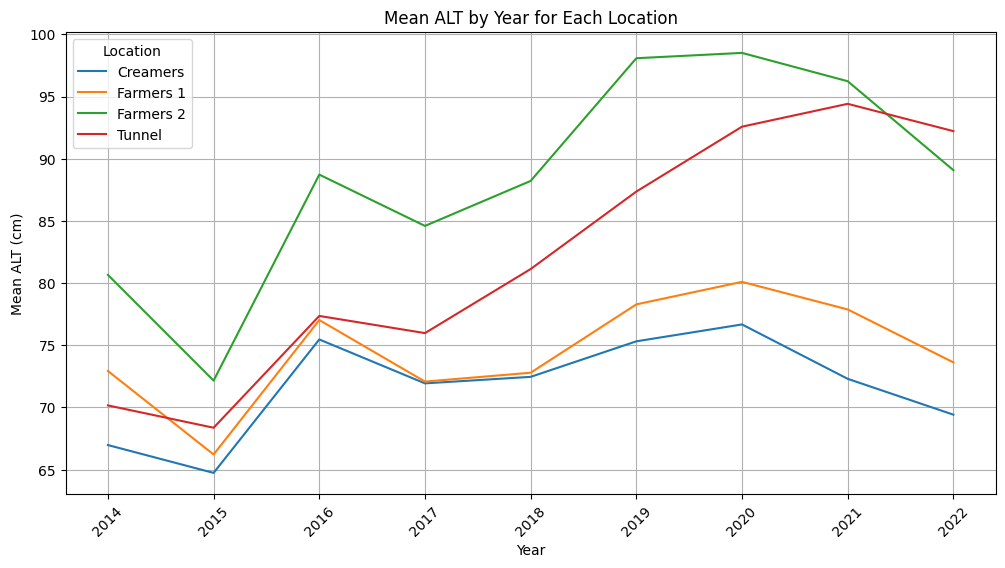

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/Azadeh/CRREL_cleaned.xlsx'
sheets = ['Creamers', 'Farmers 1', 'Farmers 2', 'Tunnel']

alt_columns_dict = {
    'Creamers': {
        'CF_10_8_14': 2014,
        'CF_09_29_15': 2015,
        'CF_10_10_16': 2016,
        'CF 10_2017': 2017,
        'CF 10_5_2018': 2018,
        'CF 10_15_19': 2019,
        'CF 10_6_20': 2020,
        'CF 10_2_21': 2021,
        'CF_9_28_22': 2022
    },
    'Farmers 1': {
        'F1_10_7_14': 2014,
        'F1_09_29_15': 2015,
        'F1_10_10_16': 2016,
        'F1 10_3_2017': 2017,
        'F1 10_10_18': 2018,
        'FL1_10_14_19': 2019,
        'FL1_10_5_20': 2020,
        '9_30_21': 2021,
        'FL1_9_27_22': 2022
    },
    'Farmers 2': {
        'F2_10_7_14': 2014,
        'F2_09_29_15': 2015,
        'F2_10_11_16': 2016,
        'F2_10_17': 2017,
        'F2_10_10_18': 2018,
        'F2_10_14_19': 2019,
        'F2_10_5_2020': 2020,
        '9_30_21': 2021,
        'F2_9_27_22': 2022
    },
    'Tunnel': {
        'PT_10_8_14': 2014,
        'PT_09_30_15': 2015,
        'PT_09_29_16': 2016,
        'PT_10_2_2017': 2017,
        'PT_10_3_2018': 2018,
        'PT_10_4_2019': 2019,
        'PT_10_5_2020': 2020,
        '10_2_21': 2021,
        'PT_9_26_22': 2022
    }
}

def gather_mean_alt(sheet_name, alt_columns):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    mean_alt_by_year = []
    
    for alt_col, year in alt_columns.items():
        df[alt_col] = pd.to_numeric(df[alt_col])
        year_mean = df[alt_col].mean()
        mean_alt_by_year.append({'Year': year, 'Mean_ALT': year_mean})

    mean_alt_by_year_df = pd.DataFrame(mean_alt_by_year)
    mean_alt_by_year_df['Location'] = sheet_name
    return mean_alt_by_year_df

all_data = pd.DataFrame()
for sheet in sheets:
    sheet_data = gather_mean_alt(sheet, alt_columns_dict[sheet])
    all_data = pd.concat([all_data, sheet_data], ignore_index=True)

pivot_data = all_data.pivot(index='Year', columns='Location', values='Mean_ALT')

plt.figure(figsize=(12, 6))
for column in pivot_data:
    plt.plot(pivot_data.index, pivot_data[column], label=column)

plt.title('Mean ALT by Year for Each Location')
plt.xlabel('Year')
plt.ylabel('Mean ALT (cm)')
plt.legend(title='Location')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Raster Data

In [97]:
ndvitry = '/Users/Azadeh/Downloads/NDVI'
ndvitrylist = glob.glob(os.path.join(ndvitry, '*'))
sortedlist = sorted(ndvitrylist)
for file in ndvitrylist:
    print(file)

print(f"Total number of files: {len(ndvitrylist)}")

/Users/Azadeh/Downloads/NDVI/CF_NDVI.tfw
/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif
/Users/Azadeh/Downloads/NDVI/WV2_NDVI.tif.aux.xml
/Users/Azadeh/Downloads/NDVI/WV2_NDVI.tif.ovr
/Users/Azadeh/Downloads/NDVI/WV2_NDVI.tfw
/Users/Azadeh/Downloads/NDVI/WV2_NDVI.tif
/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif.ovr
/Users/Azadeh/Downloads/NDVI/PT_NDVI.tif
/Users/Azadeh/Downloads/NDVI/PT_NDVI.tfw
/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif.aux.xml
/Users/Azadeh/Downloads/NDVI/FL_NDVI.tif.ovr
/Users/Azadeh/Downloads/NDVI/PT_NDVI.tif.aux.xml
/Users/Azadeh/Downloads/NDVI/PT_NDVI.tif.ovr
/Users/Azadeh/Downloads/NDVI/FL_NDVI.tif.aux.xml
/Users/Azadeh/Downloads/NDVI/FL_NDVI.tfw
/Users/Azadeh/Downloads/NDVI/FL_NDVI.tif
Total number of files: 16


In [99]:
xds = rio.open_rasterio("/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif")
xds

<xarray.DataArray (band: 1, y: 195, x: 195)> Size: 152kB
[38025 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB 4.644e+05 4.644e+05 ... 4.654e+05 4.654e+05
  * y            (y) float64 2kB 7.195e+06 7.195e+06 ... 7.194e+06 7.194e+06
    spatial_ref  int64 8B 0
Attributes: (12/13)
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  0.004174583158690265
    STATISTICS_MAXIMUM:      0.85118460655212
    STATISTICS_MEAN:         0.71759463681205
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       0.064611014221186
    _FillValue:              -3.402823e+38
    scale_factor:            1.0
    add_offset:              0.0

In [100]:
xds.values

array([[[0.7555074 , 0.75271   , 0.7424651 , ..., 0.72710764,
         0.7388886 , 0.7242467 ],
        [0.7586734 , 0.75271   , 0.75771207, ..., 0.7322539 ,
         0.7210951 , 0.72355574],
        [0.7494297 , 0.7417014 , 0.7528174 , ..., 0.63420534,
         0.7210951 , 0.7210951 ],
        ...,
        [0.5251372 , 0.7748266 , 0.7748266 , ..., 0.8163797 ,
         0.8250431 , 0.81616414],
        [0.5251372 , 0.6926813 , 0.8154578 , ..., 0.8361924 ,
         0.81996906, 0.817226  ],
        [0.6926813 , 0.8016052 , 0.8154578 , ..., 0.8269742 ,
         0.8312072 , 0.817226  ]]], dtype=float32)

In [101]:
xds.rio.crs

CRS.from_epsg(32606)

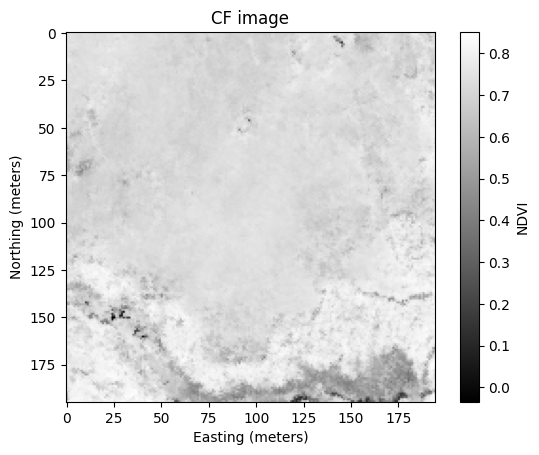

In [175]:
import matplotlib.pyplot as plt
import rasterio as rio
from pyproj import Transformer

plt.imshow(xds[0], cmap='gray')
plt.title('CF image')

plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')

plt.colorbar(label='NDVI')

plt.show()


In [103]:
xds.shape[1], xds.shape[2]

(195, 195)

In [105]:
dataset1_utm = rio.open_rasterio("/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif")

In [106]:
print(dataset1_utm.shape)

(1, 195, 195)


In [152]:
import rasterio
dataset = rasterio.open("/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif")
print(dataset.crs)
if dataset.crs == 'EPSG:32606':
    print("The dataset is in EPSG:32606 (UTM zone 6N, WGS 84).")
else:
    print("The dataset is in a different CRS.")


EPSG:32606
The dataset is in EPSG:32606 (UTM zone 6N, WGS 84).


In [158]:
from esda.moran import Moran
from libpysal.weights import lat2W

ndvi_values = ndvi_band.flatten()
w = lat2W(ndvi_band.shape[0], ndvi_band.shape[1])

moran = Moran(ndvi_values, w)
print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_sim}")


Moran's I: 0.816227721109119
P-value: 0.001


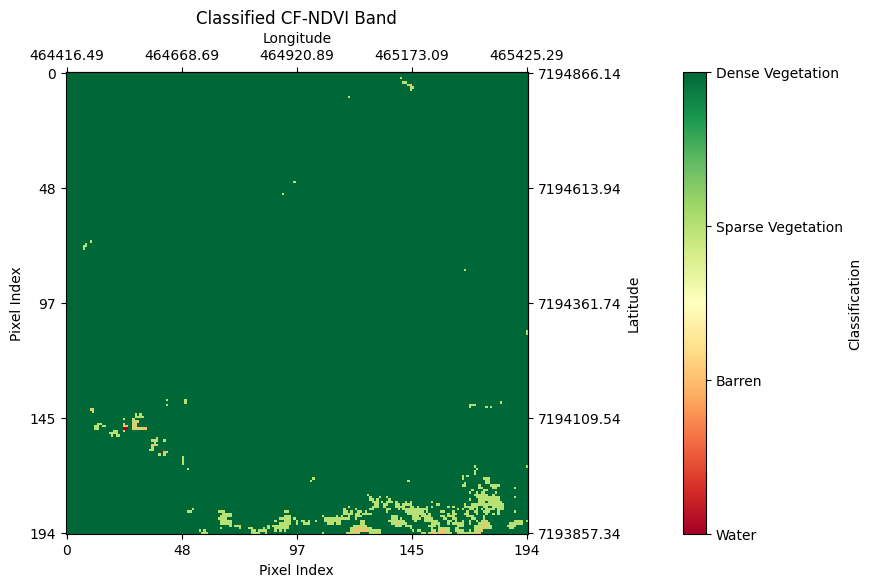

In [84]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

image_file = "/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif"
with rio.open(image_file) as src:
    ndvi_band = src.read(1)
    transform = src.transform

def pixel_to_geo(pixel_x, pixel_y, transform):
    geo_x, geo_y = rio.transform.xy(transform, pixel_y, pixel_x)
    return geo_x, geo_y

num_ticks = 5 
x_ticks = np.linspace(0, ndvi_band.shape[1] - 1, num_ticks)
y_ticks = np.linspace(0, ndvi_band.shape[0] - 1, num_ticks)
x_labels_geo = [round(pixel_to_geo(x, 0, transform)[0], 2) for x in x_ticks]
y_labels_geo = [round(pixel_to_geo(0, y, transform)[1], 2) for y in y_ticks]

classified_pixels = np.zeros_like(ndvi_band)

classified_pixels[ndvi_band < 0] = 1  # Water
classified_pixels[(ndvi_band >= 0) & (ndvi_band < 0.2)] = 2  # Barren
classified_pixels[(ndvi_band >= 0.2) & (ndvi_band < 0.5)] = 3  # Sparse Vegetation
classified_pixels[ndvi_band >= 0.5] = 4  # Dense Vegetation

fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.imshow(classified_pixels, cmap='RdYlGn', interpolation='none')  #cmap=viridis
ax.set_title('Classified CF-NDVI Band')

cbar = fig.colorbar(cax, ticks=[1, 2, 3, 4], pad=0.2)
cbar.ax.set_yticklabels(['Water', 'Barren', 'Sparse Vegetation', 'Dense Vegetation'])
cbar.set_label('Classification')

ax.set_xticks(x_ticks)
ax.set_xticklabels([int(x) for x in x_ticks])
ax.set_yticks(y_ticks)
ax.set_yticklabels([int(y) for y in y_ticks])

secax_x = ax.secondary_xaxis('top')
secax_x.set_xticks(x_ticks)
secax_x.set_xticklabels(x_labels_geo)
secax_x.set_xlabel('Longitude')

secax_y = ax.secondary_yaxis('right')
secax_y.set_yticks(y_ticks)
secax_y.set_yticklabels(y_labels_geo)
secax_y.set_ylabel('Latitude')

ax.set_xlabel('Pixel Index')
ax.set_ylabel('Pixel Index')

plt.show()


In [23]:
(classified_pixels == 1).sum()

3

In [24]:
(classified_pixels == 2).sum()

37

In [25]:
(classified_pixels == 3).sum()

652

In [26]:
(classified_pixels == 4).sum()

37333

In [75]:
import rasterio as rio
with rio.open(image_file) as src:
    ndvi_band = src.read(1)
    transform = src.transform
    pixel_area = abs(transform[0] * transform[4])


In [32]:
import numpy as np
unique_classes, counts = np.unique(classified_pixels, return_counts=True)
areas = counts * pixel_area 

df_classification = pd.DataFrame(list(zip(unique_classes, counts, areas)),
                                 columns=['Class', 'Count', 'Area'])

class_labels = {1: 'Water', 2: 'Barren', 3: 'Sparse Vegetation', 4: 'Dense Vegetation'}
df_classification['Class Label'] = df_classification['Class'].map(class_labels)

total_area = df_classification['Area'].sum()
df_classification['Fraction (%)'] = (df_classification['Area'] / total_area) * 100

print(df_classification[['Class Label', 'Count', 'Area', 'Fraction (%)']])

         Class Label  Count        Area  Fraction (%)
0              Water      3       81.12      0.007890
1             Barren     37     1000.48      0.097304
2  Sparse Vegetation    652    17630.08      1.714661
3   Dense Vegetation  37333  1009484.32     98.180145


In [76]:
import rasterio as rio

# Load the NDVI image
image_file = "/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif"
with rio.open(image_file) as src:
    metadata = src.meta
    print("Metadata:", metadata)

    crs = src.crs
    print("Coordinate Reference System (CRS):", crs)

    bounds = src.bounds
    print("Bounds:", bounds)

    transform = src.transform
    print("Transform:", transform)
    
    geo_coords = rio.transform.xy(transform, 0, 0)
    print("Geographical coordinates of pixel (0,0):", geo_coords)

    band_description = src.descriptions[0] if src.descriptions else None
    print("Band Description:", band_description)


Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028230607370965e+38, 'width': 195, 'height': 195, 'count': 1, 'crs': CRS.from_epsg(32606), 'transform': Affine(5.2, 0.0, 464413.894,
       0.0, -5.2, 7194868.73508214)}
Coordinate Reference System (CRS): EPSG:32606
Bounds: BoundingBox(left=464413.894, bottom=7193854.73508214, right=465427.894, top=7194868.73508214)
Transform: | 5.20, 0.00, 464413.89|
| 0.00,-5.20, 7194868.74|
| 0.00, 0.00, 1.00|
Geographical coordinates of pixel (0,0): (464416.49399999995, 7194866.135082141)
Band Description: None


GeoDataFrame CRS: epsg:32606


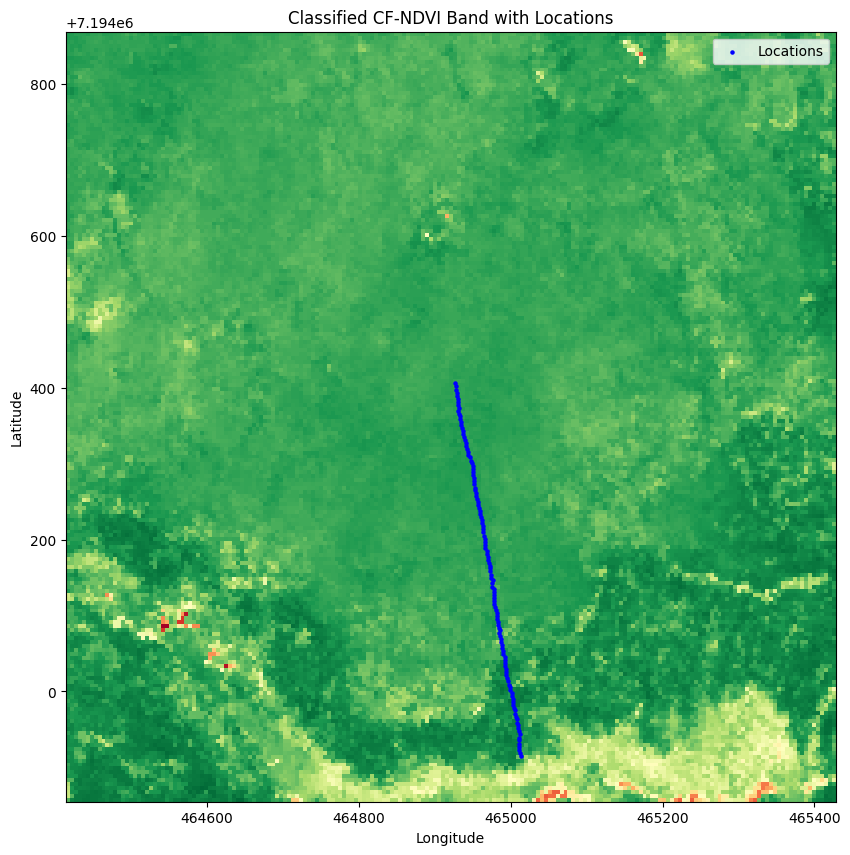

In [86]:
import rasterio as rio
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from pyproj import Transformer

ndvi_file = "/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif"
with rio.open(ndvi_file) as src:
    ndvi_band = src.read(1)
    transform = src.transform
    bounds = src.bounds
    crs = src.crs

excel_file = "/Users/Azadeh/CRREL_cleaned.xlsx"
coordinates_df = pd.read_excel(excel_file)

latitudes = coordinates_df['CF_Northing_m'].values
longitudes = coordinates_df['CF_Easting_m'].values

transformer = Transformer.from_crs("epsg:32606", crs.to_string(), always_xy=True)

def reproject_coordinates(x, y):
    return transformer.transform(x, y)

reprojected_coords = [reproject_coordinates(lon, lat) for lon, lat in zip(longitudes, latitudes)]

geometry = [Point(xy) for xy in reprojected_coords]
gdf = gpd.GeoDataFrame(coordinates_df, geometry=geometry, crs="epsg:32606")

print("GeoDataFrame CRS:", gdf.crs)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(ndvi_band, cmap='RdYlGn', extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
ax.set_title('Classified CF-NDVI Band with Locations')

gdf.plot(ax=ax, marker='o', color='blue', markersize=5, label='Locations')

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.savefig('/Users/Azadeh/Downloads/NDVI/NDVI_with_Locations.jpg', format='jpeg')
plt.show()


In [174]:
import rasterio as rio
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from pyproj import Transformer

ndvi_file = "/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif"
with rio.open(ndvi_file) as src:
    ndvi_band = src.read(1)
    ndvi_crs = src.crs
    transform = src.transform
    bounds = src.bounds

print("NDVI Image CRS:", ndvi_crs)


NDVI Image CRS: EPSG:32606


In [160]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

reprojected_image_file = "/Users/Azadeh/Downloads/NDVI/reprojected_CFNDVI_image.tif"

with rio.open(image_file) as src:
    dst_crs = 'EPSG:4326'
    
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rio.open(reprojected_image_file, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)


In [161]:
with rio.open(reprojected_image_file) as src:
    ndvi_band_reprojected = src.read(1)
    transform_reprojected = src.transform

geo_coords_reprojected = rio.transform.xy(transform_reprojected, 0, 0)
print("Geographical coordinates of pixel (0,0) after reprojection:", geo_coords_reprojected)

Geographical coordinates of pixel (0,0) after reprojection: (-147.75113244169546, 64.87626478472961)


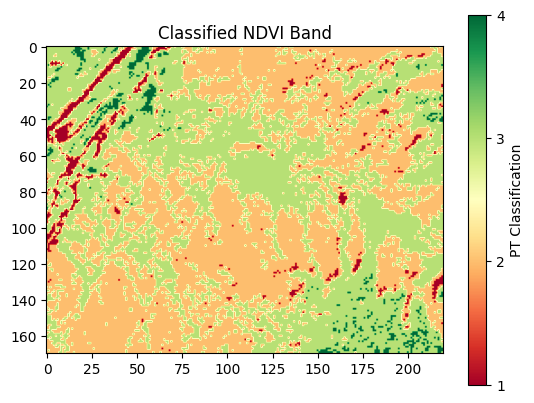

In [89]:
dataset3_utm = rio.open("/Users/Azadeh/Downloads/NDVI/PT_NDVI.tif")
dataset3_utm_np = dataset3_utm.read(1)
classified_pixels = np.zeros_like(dataset3_utm_np)

classified_pixels[dataset3_utm_np < 0] = 1
classified_pixels[(dataset3_utm_np >= 0) & (dataset3_utm_np < 0.2)] = 2
classified_pixels[(dataset3_utm_np >= 0.2) & (dataset3_utm_np < 0.5)] = 3
classified_pixels[dataset3_utm_np >= 0.5] = 4

plt.imshow(classified_pixels, cmap='RdYlGn')
plt.title('Classified NDVI Band')
plt.colorbar(ticks=[0, 1, 2, 3, 4], label='PT Classification')
plt.show()

In [117]:
waterpixels = (classified_pixels == 1).sum()
waterpixels

1096

In [119]:
Barrenpixels = (classified_pixels == 2).sum()
Barrenpixels

18187

In [120]:
Sparsepixels = (classified_pixels == 3).sum()
Sparsepixels

17395

In [121]:
Densepixels = (classified_pixels == 4).sum()
Densepixels

722

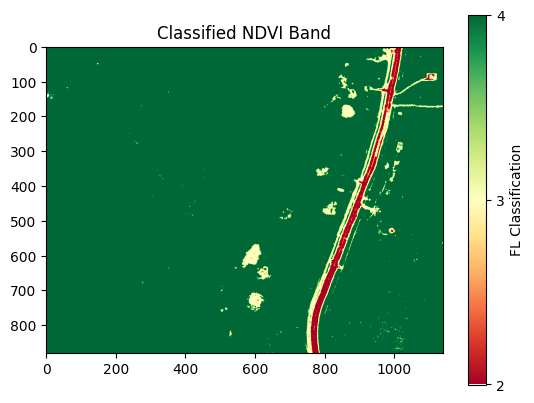

In [90]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

dataset4_utm = rio.open("/Users/Azadeh/Downloads/NDVI/FL_NDVI.tif")

dataset4_utm_np = dataset4_utm.read(1)

classified_pixels = np.zeros_like(dataset4_utm_np)

classified_pixels[dataset4_utm_np < 0] = 1
classified_pixels[(dataset4_utm_np >= 0) & (dataset4_utm_np < 0.2)] = 2
classified_pixels[(dataset4_utm_np >= 0.2) & (dataset4_utm_np < 0.5)] = 3
classified_pixels[dataset4_utm_np >= 0.5] = 4

plt.imshow(classified_pixels, cmap='RdYlGn')
plt.title('Classified NDVI Band')
plt.colorbar(ticks=[1, 2, 3, 4], label='FL Classification')
plt.show()


Mean: 0.7175946235656738, Median: 0.726357102394104, Std Dev: 0.06461016088724136, Min: -0.03446187824010849, Max: 0.851184606552124


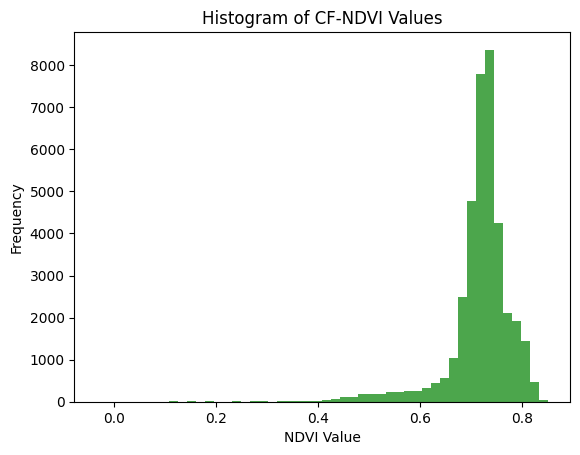

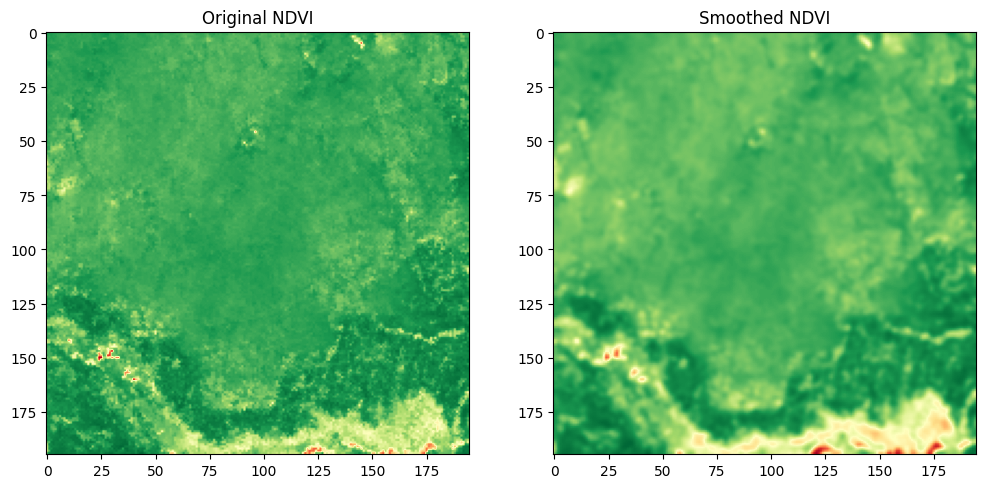

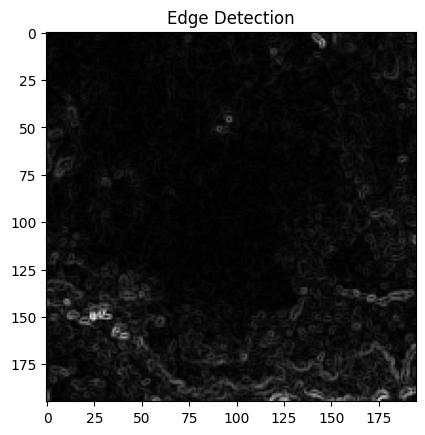

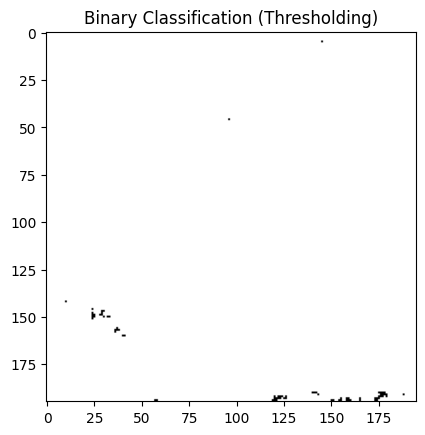

In [134]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import filters

image_file = "/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif"

with rasterio.open(image_file) as src:
    band = src.read(1) 

mean_value = np.mean(band)
median_value = np.median(band)
std_dev = np.std(band)
min_value = np.min(band)
max_value = np.max(band)

print(f"Mean: {mean_value}, Median: {median_value}, Std Dev: {std_dev}, Min: {min_value}, Max: {max_value}")

plt.hist(band.flatten(), bins=50, color='green', alpha=0.7)
plt.title('Histogram of CF-NDVI Values')
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.show()

smoothed_band = gaussian_filter(band, sigma=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(band, cmap='RdYlGn')
ax[0].set_title('Original NDVI')
ax[1].imshow(smoothed_band, cmap='RdYlGn')
ax[1].set_title('Smoothed NDVI')
plt.show()

edges = filters.sobel(band)

plt.imshow(edges, cmap='gray')
plt.title('Edge Detection')
plt.show()

threshold = 0.3
binary_classification = (band > threshold).astype(int)

plt.imshow(binary_classification, cmap='gray')
plt.title('Binary Classification (Thresholding)')
plt.show()


In [26]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

Creamers = gpd.read_file('/Users/Azadeh/Downloads/Shapefiles/Creamers_Field.shp')
Creamers.head()

Mean_Layer  Mean_Lay_1  Mean_Lay_2  Mean_Lay_3  Mean_Lay_4  Mean_Lay_5  \
0   -4.297105   -0.444402    0.107883    0.868580   -0.504964    2.182119   
1   -5.608564   -0.765248    0.836958    2.605786   -1.820469    1.362572   
2   -4.691170   -1.355266   -0.019365    5.138265   -0.116034    3.636818   
3    0.330251   -0.507248   -1.215054    6.478460    1.571896    3.436071   
4   -5.657718   -0.135277   -0.452446    4.560037   -1.372984    3.539133   

   Mean_Lay_6  Mean_Lay_7  Mean_Lay_8  Mean_Lay_9  ...      NDVI       CHM  \
0    1.747794    0.868194   -0.040216   -0.182877  ...  0.733303  0.541310   
1    0.602669    0.901093    0.205720    1.196936  ...  0.731732  0.396310   
2    2.206680   -1.246705    0.377954    2.268642  ...  0.743029  1.010550   
3    4.558614   -3.309943   -0.243250    2.789256  ...  0.751909  1.661450   
4    0.867504   -0.419531   -0.206643    1.498612  ...  0.745014  0.552109   

       DSM      DTM  NDVI_STD   CHM_STD   DSM_STD   DTM_STD   Pred_Veg  \
0  139.108  138.567  0.007667  0.654383  0.000000  0.000000        Fen   
1  138.970  138.574  0.006758  0.657662  0.657669  0.084299        Fen   
2  139.609  138.599  0.014515  1.317420  0.662122  0.083998  Shrubland   
3  140.250  138.588  0.013598  1.672590  1.275890  0.119287  Shrubland   
4  139.241  138.689  0.008976  0.663455  1.623540  0.117372  Shrubland   

                                            geometry  
0  POLYGON Z ((464434.694 7194868.735 0.000, 4644...  
1  POLYGON Z ((464471.094 7194868.735 0.000, 4645...  
2  POLYGON Z ((464523.094 7194868.735 0.000, 4645...  
3  POLYGON Z ((464549.094 7194868.735 0.000, 4645...  
4  POLYGON Z ((464564.694 7194868.735 0.000, 4645...  

[5 rows x 30 columns]

In [27]:
Creamers.dtypes

Mean_Layer     float64
Mean_Lay_1     float64
Mean_Lay_2     float64
Mean_Lay_3     float64
Mean_Lay_4     float64
Mean_Lay_5     float64
Mean_Lay_6     float64
Mean_Lay_7     float64
Mean_Lay_8     float64
Mean_Lay_9     float64
Standard_d     float64
Standard_1     float64
Standard_2     float64
Standard_3     float64
Standard_4     float64
Standard_5     float64
Standard_6     float64
Standard_7     float64
Standard_8     float64
Standard_9     float64
NDVI           float64
CHM            float64
DSM            float64
DTM            float64
NDVI_STD       float64
CHM_STD        float64
DSM_STD        float64
DTM_STD        float64
Pred_Veg        object
geometry      geometry
dtype: object

In [28]:
Creamers.shape

(5205, 30)

In [29]:
Creamers.columns

Index(['Mean_Layer', 'Mean_Lay_1', 'Mean_Lay_2', 'Mean_Lay_3', 'Mean_Lay_4',
       'Mean_Lay_5', 'Mean_Lay_6', 'Mean_Lay_7', 'Mean_Lay_8', 'Mean_Lay_9',
       'Standard_d', 'Standard_1', 'Standard_2', 'Standard_3', 'Standard_4',
       'Standard_5', 'Standard_6', 'Standard_7', 'Standard_8', 'Standard_9',
       'NDVI', 'CHM', 'DSM', 'DTM', 'NDVI_STD', 'CHM_STD', 'DSM_STD',
       'DTM_STD', 'Pred_Veg', 'geometry'],
      dtype='object')

In [ ]:
Creamers['area'] = Creamers['geometry'].area
Creamers.head()

In [36]:
Creamers.crs

<Projected CRS: EPSG:32606>
Name: WGS 84 / UTM zone 6N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 150°W and 144°W, northern hemisphere between equator and 84°N, onshore and offshore. United States (USA) - Alaska (AK).
- bounds: (-150.0, 0.0, -144.0, 84.0)
Coordinate Operation:
- name: UTM zone 6N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
counties_reproject = counties.to_crs('EPSG:4326')
counties_reproject.crs

In [ ]:
Creamers.nlargest(n=10, columns='area')

In [ ]:
Creamers['perimeter'] = Creamers['geometry'].length
Creamers.head()

In [ ]:
Creamers['centroid'] = Creamers['geometry'].centroid
Creamers.head()

In [43]:
import geopandas as gpd

shapefile_path = '/Users/Azadeh/Downloads/Shapefiles/Creamers_Field.shp'
gdf = gpd.read_file(shapefile_path)

gdf['latitude'] = gdf.geometry.apply(lambda geom: geom.y if geom.geom_type == 'Point' else None)
gdf['longitude'] = gdf.geometry.apply(lambda geom: geom.x if geom.geom_type == 'Point' else None)

gdf['area'] = gdf.geometry.apply(lambda geom: geom.area if geom.geom_type == 'Polygon' else None)

gdf['centroid'] = gdf.geometry.apply(lambda geom: geom.centroid if geom.geom_type == 'Polygon' else None)

gdf['centroid_latitude'] = gdf['centroid'].apply(lambda point: point.y if point else None)
gdf['centroid_longitude'] = gdf['centroid'].apply(lambda point: point.x if point else None)

gdf['row_number'] = gdf.index + 1
selected_columns = ['row_number', 'NDVI', 'Pred_Veg', 'geometry', 'latitude', 'longitude', 'area', 'centroid_latitude', 'centroid_longitude']

output_df = gdf[selected_columns]

csv_output_path = '/Users/Azadeh/Downloads/Creamers_Field_with_lat_lon_and_area.csv'
output_df.to_csv(csv_output_path, index=False)

print("CSV file created at:", csv_output_path)


CSV file created at: /Users/Azadeh/Downloads/Creamers_Field_with_lat_lon_and_area.csv


In [45]:
import geopandas as gpd
from shapely.geometry import Point

shapefile_path = '/Users/Azadeh/Downloads/Shapefiles/Creamers_Field.shp'
gdf = gpd.read_file(shapefile_path)

gdf['centroid'] = gdf.geometry.apply(lambda geom: geom.centroid if geom.geom_type == 'Polygon' else None)

gdf['centroid_latitude'] = gdf['centroid'].apply(lambda point: point.y if point else None)
gdf['centroid_longitude'] = gdf['centroid'].apply(lambda point: point.x if point else None)

gdf_reprojected = gdf.to_crs('EPSG:32610')

first_centroid = gdf_reprojected.iloc[0].centroid

gdf_reprojected['dist_from_first_centroid'] = gdf_reprojected.centroid.distance(first_centroid) / 1000

distances = gdf_reprojected.centroid.apply(lambda point: gdf_reprojected.centroid.distance(point) / 1000)

distance_df = distances.apply(pd.Series)
distance_csv_path = '/Users/Azadeh/Downloads/Centroid_Distances.csv'
distance_df.to_csv(distance_csv_path, index=False)

gdf_reprojected['row_number'] = gdf_reprojected.index + 1
selected_columns = ['row_number', 'NDVI', 'Pred_Veg', 'geometry', 'centroid_latitude', 'centroid_longitude', 'dist_from_first_centroid']

output_df = gdf_reprojected[selected_columns]

csv_output_path = '/Users/Azadeh/Downloads/Creamers_Field_with_distances.csv'
output_df.to_csv(csv_output_path, index=False)

print("CSV file with centroid distances created at:", csv_output_path)
print("CSV file with pairwise distances created at:", distance_csv_path)


CSV file with centroid distances created at: /Users/Azadeh/Downloads/Creamers_Field_with_distances.csv
CSV file with pairwise distances created at: /Users/Azadeh/Downloads/Centroid_Distances.csv


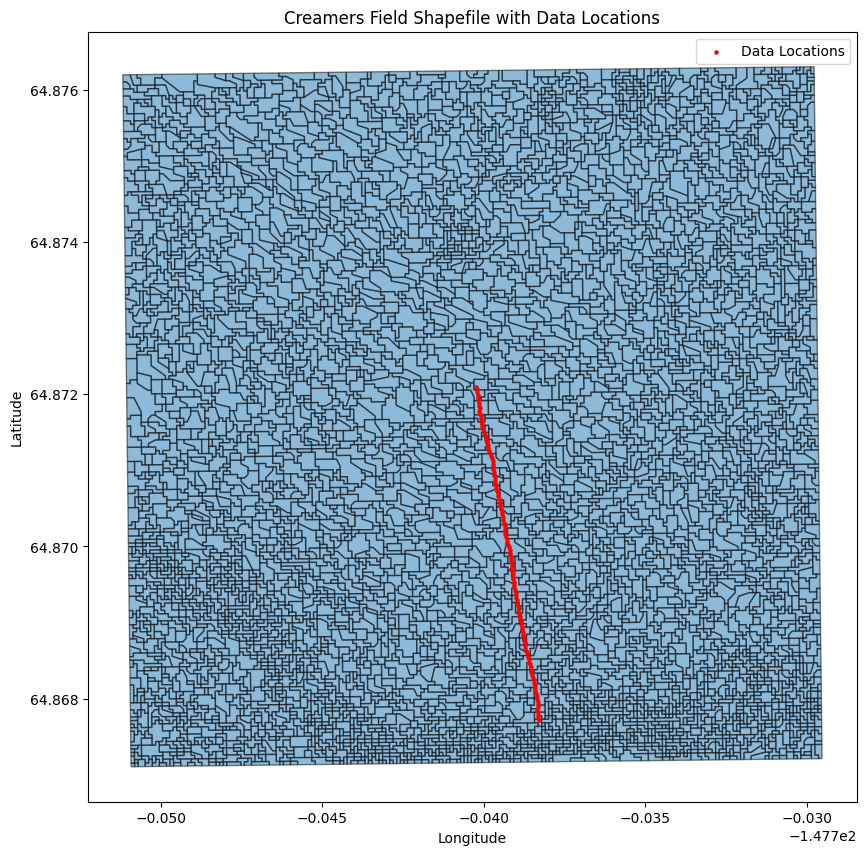

In [91]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Transformer

shapefile_path = '/Users/Azadeh/Downloads/Shapefiles/Creamers_Field.shp'
excel_file_path = '/Users/Azadeh/CRREL.xlsx'
gdf = gpd.read_file(shapefile_path)
df = pd.read_excel(excel_file_path, sheet_name='Creamers')

if 'CF_Easting_m' in df.columns and 'CF_Northing_m' in df.columns:
    transformer = Transformer.from_crs("epsg:32606", "epsg:4326", always_xy=True)
    df[['longitude', 'latitude']] = df.apply(
        lambda row: pd.Series(transformer.transform(row['CF_Easting_m'], row['CF_Northing_m'])), axis=1
    )
    
    df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    locations_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="epsg:4326")
    
    gdf = gdf.to_crs("epsg:4326")
    ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
    locations_gdf.plot(ax=ax, color='red', markersize=5, label='Data Locations')
    
    plt.title('Creamers Field Shapefile with Data Locations')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.savefig('/Users/Azadeh/creamers_field_plot.jpg', format='jpeg')

    plt.show()
else:
    print("Required columns 'CF_Easting_m' and 'CF_Northing_m' not found in the dataset.")

Index(['Mean_Layer', 'Mean_Lay_1', 'Mean_Lay_2', 'Mean_Lay_3', 'Mean_Lay_4',
       'Mean_Lay_5', 'Mean_Lay_6', 'Mean_Lay_7', 'Mean_Lay_8', 'Mean_Lay_9',
       'Standard_d', 'Standard_1', 'Standard_2', 'Standard_3', 'Standard_4',
       'Standard_5', 'Standard_6', 'Standard_7', 'Standard_8', 'Standard_9',
       'NDVI', 'CHM', 'DSM', 'DTM', 'NDVI_STD', 'CHM_STD', 'DSM_STD',
       'DTM_STD', 'Pred_Veg', 'geometry'],
      dtype='object')


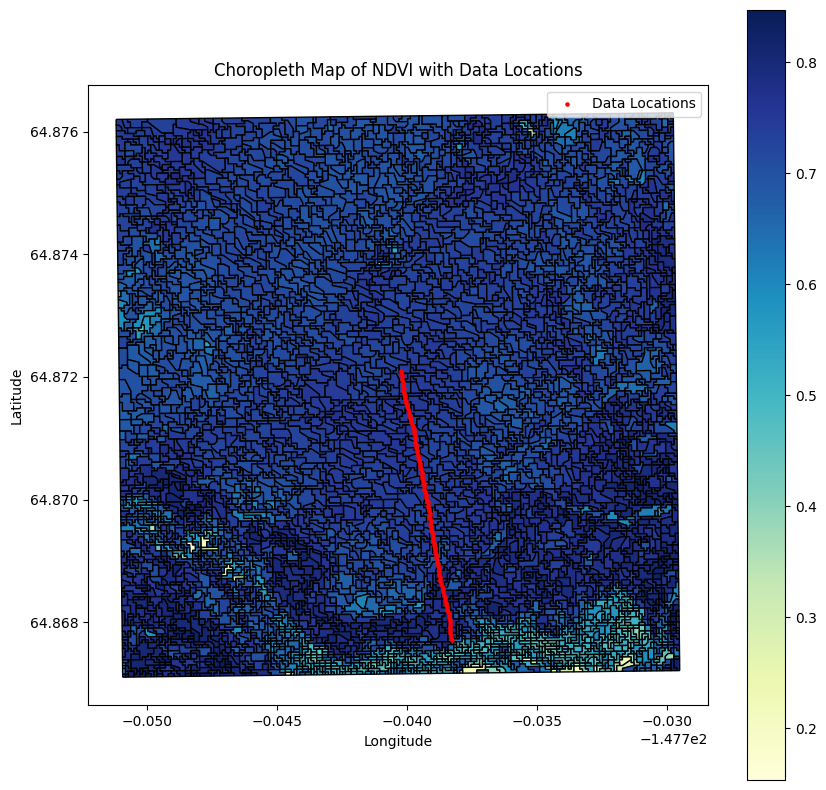

In [93]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Transformer

shapefile_path = '/Users/Azadeh/Downloads/Shapefiles/Creamers_Field.shp'
gdf = gpd.read_file(shapefile_path)

print(gdf.columns)


gdf['NDVI'] = gdf['NDVI'].astype(float)

excel_file_path = '/Users/Azadeh/CRREL.xlsx'
df = pd.read_excel(excel_file_path, sheet_name='Creamers')

if 'CF_Easting_m' in df.columns and 'CF_Northing_m' in df.columns:
    transformer = Transformer.from_crs("epsg:32606", "epsg:4326", always_xy=True)
    df[['longitude', 'latitude']] = df.apply(
        lambda row: pd.Series(transformer.transform(row['CF_Easting_m'], row['CF_Northing_m'])), axis=1
    )
    
    df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    locations_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="epsg:4326")
    
    gdf = gdf.to_crs("epsg:4326")
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf.plot(column='NDVI', ax=ax, legend=True, cmap='YlGnBu', edgecolor='k')
    
    locations_gdf.plot(ax=ax, color='red', markersize=5, label='Data Locations')
    
    plt.title('Choropleth Map of NDVI with Data Locations')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    
    plt.savefig('/Users/Azadeh/creamers_field_ndvi_locations_plot.jpg', format='jpeg')
    
    plt.show()
else:
    print("Required columns 'CF_Easting_m' and 'CF_Northing_m' not found in the dataset.")


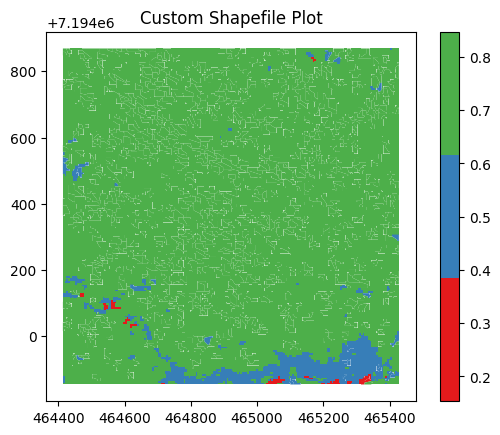

In [74]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
gdf.plot(column='NDVI', cmap=cmap, legend=True)
plt.title('Custom Shapefile Plot')
plt.show()


   Mean_Layer  Mean_Lay_1  Mean_Lay_2  Mean_Lay_3  Mean_Lay_4  Mean_Lay_5  \
0   -4.297105   -0.444402    0.107883    0.868580   -0.504964    2.182119   
1   -5.608564   -0.765248    0.836958    2.605786   -1.820469    1.362572   
2   -4.691170   -1.355266   -0.019365    5.138265   -0.116034    3.636818   
3    0.330251   -0.507248   -1.215054    6.478460    1.571896    3.436071   
4   -5.657718   -0.135277   -0.452446    4.560037   -1.372984    3.539133   

   Mean_Lay_6  Mean_Lay_7  Mean_Lay_8  Mean_Lay_9  ...      NDVI       CHM  \
0    1.747794    0.868194   -0.040216   -0.182877  ...  0.733303  0.541310   
1    0.602669    0.901093    0.205720    1.196936  ...  0.731732  0.396310   
2    2.206680   -1.246705    0.377954    2.268642  ...  0.743029  1.010550   
3    4.558614   -3.309943   -0.243250    2.789256  ...  0.751909  1.661450   
4    0.867504   -0.419531   -0.206643    1.498612  ...  0.745014  0.552109   

       DSM      DTM  NDVI_STD   CHM_STD   DSM_STD   DTM_STD   Pred_V

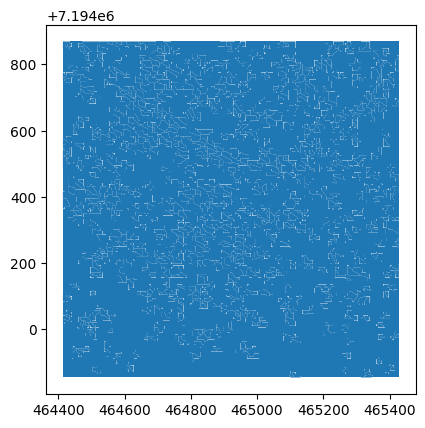

In [78]:
import geopandas as gpd

\gdf = gpd.read_file('/Users/Azadeh/Downloads/Shapefiles/Creamers_Field.shp')

print(gdf.head())

print(gdf.info())

gdf.plot()
plt.show()


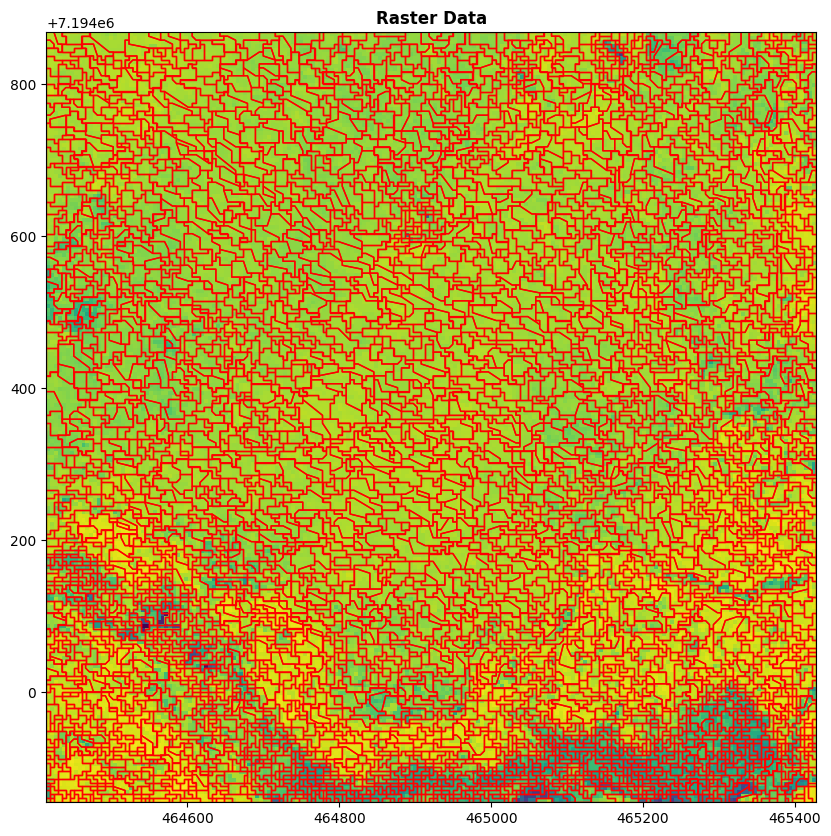

In [2]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import numpy as np

shapefile_path = '/Users/Azadeh/Downloads/Shapefiles/Creamers_Field.shp'
gdf = gpd.read_file(shapefile_path)

tiff_path = '/Users/Azadeh/Downloads/NDVI/CF_NDVI.tif'
raster = rasterio.open(tiff_path)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
show(raster, ax=ax, title='Raster Data')
gdf.plot(ax=ax, facecolor='none', edgecolor='red')
plt.show()
